In [5]:
import numpy as np
import os
import util as u
from MRI_layers_MK1 import *
import matplotlib.pyplot as plt
import pickle

In [6]:
#base path to folder with scan data 
base = "/Users/nathanielnethercott/Desktop/School/2021/Pickled_Sample/"
fpaths = [os.path.join(base,p) for p in os.listdir(base)]

In [7]:
#test here represents data for first subject
test = pickle.load(open(fpaths[0], 'rb'))

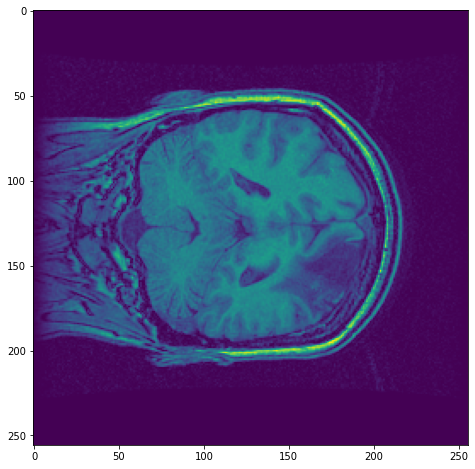

In [8]:
#split subject data into raw images and masks 
t1 = test[1]
t2 = test[2]

plt.figure(figsize=(8,8))
plt.imshow(t1[:,:,41])

In [9]:
#ignore this for the example

#my versions of some functions 
def _find_layers(mask_data):
    l = []
    for i in range(mask_data.shape[-1]):
        if np.mean(mask_data[:,:,i])>0.0:
            l.append(i)
    return l

def _area(mask):
    area = 0
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j]!=0:
                area+=1
    return area 

def _com(mask, target = 1.0):
    """
    ayo, not worth the effort rn to fill in a contour and average points
    --- lets just average y and x of contour boundaries
    
    ideally should work with contours too
    """
    indeces = []
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j]==target:
                indeces.append((i,j))
                
    _x = lambda pair: pair[0]
    _y = lambda pair: pair[1]
    
    #for some reason sorting didn't work and i'm mad about that 
    xvals = [_x(p) for p in indeces]
    yvals = [_y(p) for p in indeces]
    
    return (int(np.mean(xvals)), int(np.mean(yvals)))

#_find_layers(t2)

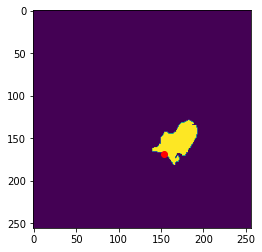

In [10]:
#normalize 
m = t2[:,:,41]/255

#find com and plot 
c = _com(m)
plt.imshow(m)
plt.plot(c[0], c[1], 'o', color = 'red')

#okay its not mad accurate but its close non?
#okay we have a ~semblance~ of where it shold be 

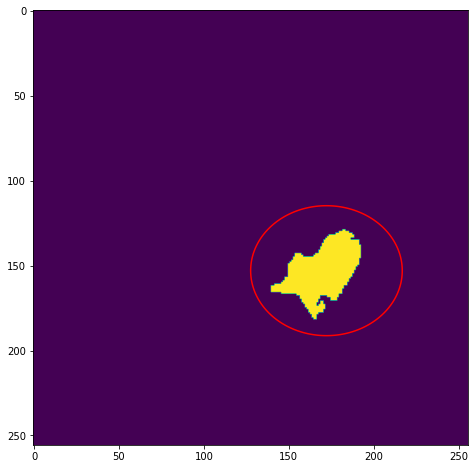

In [11]:
#try to get the segmentation functional going 
p = u.parabloid(m.shape, xrad = 0.35, yrad = 0.3, left=0.35, top = 0.2)

plt.figure(figsize=(8,8))
plt.contour(p, [0], colors=['red'])
plt.imshow(m)

In [12]:
def iteration(surface, image, dt=0.0001, alpha = 1, beta=1):
    d = lambda x,y: (x**2 + y**2)**0.5

    #absolutely do not forget to add this grid spacing in the function argument 
    sy, sx = np.gradient(surface, np.linspace(-1,1, surface.shape[0]), np.linspace(-1,1, surface.shape[1]))

    #write logic for the time evolution of the curves 
    #surface curvature 
    K = u.mean_curvature(surface)

    #now the evolution function:
    F1 = K
    F2 = (image-1.0)**2 - (image - np.zeros(image.shape))**2

    surface = surface - (beta*F2+alpha*F1)*d(sx,sy)*dt

    return surface

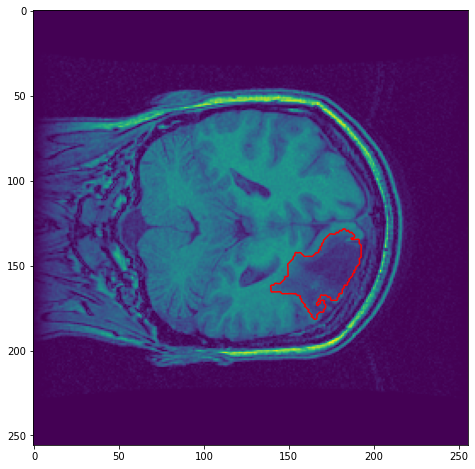

In [13]:
g = p

for i in range(1200):
    g = iteration(g, m, dt = 0.001, beta=0.11, alpha=0.001)

plt.figure(figsize=(8,8))
plt.contour(g, [0], colors=['red'])
plt.imshow(t1[:,:,41])

In [ ]:
"""
Notes: 
WE ABSOLUTELY NEED THAT SPACING DEFINED IN GRADIENT COMPUTATION, JUST TRUST MAN 
"""

In [56]:
#now lets try to determine average intensity and such 

def lesion_intensity(scans, masks, mode = "perscan"):
    """
    calculate some average intensities per scan or one representative per patient 
    
    perscan mode returns a dict with scan indeces as keys corresponding to the images with lesions 
    present, and values corresponding to average intensity 
    
    perpatient mode returns single 'average intensity'
    
    """
    
    if mode == "perscan":
        lesion_dict = {l:None for l in _find_layers(masks)}
        
        for index in lesion_dict.keys():
            #get indeces
            norm_mask = masks[:,:,index]/255
            norm_scan = scans[:,:,index]/255
            lesion_points = list(zip(*np.where(norm_mask==1.0)))
        
            #calculate the average 
            average = 0
            for p in lesion_points:
                average += (1/len(lesion_points))*norm_scan[p]

            lesion_dict[index] = average
        
        return lesion_dict
            
    
    if mode == "perpatient":
        intensity = 0
        num_lesion_points = 0
        
        indeces = _find_layers(masks)
        
        for index in indeces:
            #get indeces
            norm_mask = masks[:,:,index]/255
            norm_scan = scans[:,:,index]/255
            lesion_points = list(zip(*np.where(norm_mask==1.0)))

            for p in lesion_points:
                #add to net intensity 
                intensity+=norm_scan[p]
                
                #add to number of total points 
                num_lesion_points+=1
        
        return intensity/num_lesion_points
    

Text(0.5, 1.0, 'histogram of scan intensities')

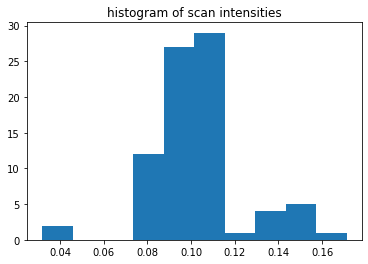

In [58]:
lesion_dict = lesion_intensity(t1,t2, mode="perscan")
_ = plt.hist(lesion_dict.values())
plt.title('histogram of scan intensities')

In [57]:
lesion_intensity(t1,t2, mode="perpatient")

0.10081445520557394

In [60]:
#okay now lets run through all the datafiles i got 

subjects_l = {k:None for k in range(len(fpaths))}

for key in subjects_l.keys():
    #get data 
    data = pickle.load(open(fpaths[key], 'rb'))
    scans = data[1]
    masks = data[2]
    
    #now lets do the thing 
    subjects_l[key] = lesion_intensity(scans,masks, mode="perpatient")
    


(array([2., 2., 0., 0., 2., 0., 1., 0., 1., 3.]),
 array([0.09702721, 0.11275113, 0.12847506, 0.14419898, 0.1599229 ,
        0.17564683, 0.19137075, 0.20709467, 0.2228186 , 0.23854252,
        0.25426645]),
 <BarContainer object of 10 artists>)

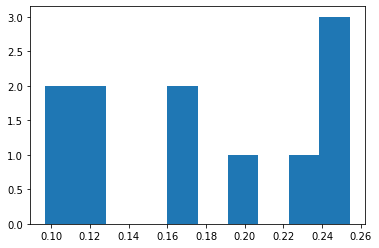

In [61]:
plt.hist(subjects_l.values())

In [ ]:
'''
although thats a decent spread, its really only 15% in the grand scheme of things 
'''

In [ ]:
#okay now lets look at the average percent change in area from scan to scan between patients

In [86]:
subjects_a = {k:None for k in range(len(fpaths))}

for key in subjects_a.keys():
    #get data 
    data = pickle.load(open(fpaths[key], 'rb'))
    scans = data[1]
    masks = data[2]
    
    #now lets do the thing: 
    indeces = _find_layers(masks)
    areas = [_area(masks[:,:,i]) for i in indeces]
    diff_areas = np.diff(areas)
    percent_change = [abs(diff_areas[i])/areas[i] for i in range(len(diff_areas))]
        
    #now append 
    subjects_a[key] = np.mean(percent_change)

In [87]:
subjects_a

{0: 0.12256009912542198,
 1: 0.2672442581728577,
 2: 0.1888922880316885,
 3: 0.27189596736312854,
 4: 0.15808763283737293,
 5: 0.412695104370062,
 6: 0.12228713368195307,
 7: 0.35137765097520135,
 8: 0.8146197671526165,
 9: 0.17512257530878567,
 10: 0.2716530277525345}

(array([5., 0., 3., 1., 1., 0., 0., 0., 0., 1.]),
 array([0.12228713, 0.1915204 , 0.26075366, 0.32998692, 0.39922019,
        0.46845345, 0.53768671, 0.60691998, 0.67615324, 0.7453865 ,
        0.81461977]),
 <BarContainer object of 10 artists>)

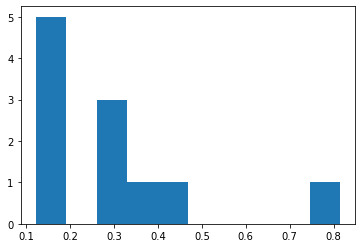

In [88]:
plt.hist(subjects_a.values())

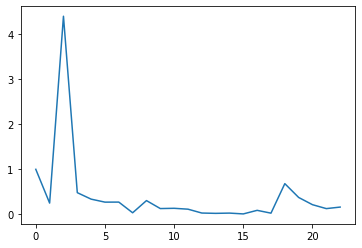

In [89]:
data = pickle.load(open(fpaths[5], 'rb'))
scans = data[1]
masks = data[2]

indeces = _find_layers(masks)
areas = [_area(masks[:,:,i]) for i in indeces]
diff_areas = np.diff(areas)
percent_change = [abs(diff_areas[i])/areas[i] for i in range(len(diff_areas))]
plt.plot(percent_change)

In [104]:
areas[1]

8